In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

# Parameters for Part 1
N = 1000
phi = 0.05
sigma = 1.0
L = np.sqrt(N * np.pi * sigma**2 / (4 * phi))
delta_ratios = np.array([0.001, 0.003, 0.01, 0.03, 0.1, 0.3])
delta_values = delta_ratios * sigma
MC_steps = 1000

#Parameters for part 5
Lx=15
Ly=10 * Lx
G = [0, 0.01, 0.1, 1, 10]
m = 1.0   
kT = 1.0  

@jit(nopython=True)
def min_image_distance_vectorized(r1, r2, L):
    """Compute minimum image distance between r1 and r2 under PBCs."""
    dr = r1 - r2
    dr = dr - L * np.round(dr / L)
    return np.sqrt(np.sum(dr**2, axis=-1))

@jit(nopython=True)
def check_overlap_vectorized(positions, i, new_pos, sigma, L):
    """Check if new_pos for particle i overlaps with any other particles."""
    mask = np.ones(len(positions), dtype=np.bool_)
    mask[i] = False
    
    distances = min_image_distance_vectorized(new_pos, positions[mask], L)
    
    
    return np.any(distances <  sigma)

@jit(nopython=True)
def initialize_positions_fast(N, L, sigma, max_attempts=10000):
    """Initialize N particle positions in LxL box without overlaps using a grid-based method."""
    positions = np.zeros((N, 2))
    
    grid_size = int(np.sqrt(N)) + 1
    spacing = L / grid_size
    
    k = 0
    for i in range(grid_size):
        for j in range(grid_size):
            if k < N:
                positions[k] = [(i + 0.5) * spacing, (j + 0.5) * spacing]
                k += 1
    
    positions += (np.random.rand(N, 2) - 0.5) * spacing * 0.1
    positions = positions % L
    
    return positions

@jit(nopython=True)
def metropolis_step_vectorized(positions, delta, L, sigma):
    """Perform one Metropolis step for all particles in a vectorized manner under PBCs."""
    N = len(positions)
    
    particle_indices = np.random.randint(0, N, N)
    displacements = (np.random.rand(N, 2) - 0.5) * delta
    
    for i in range(N):
        idx = particle_indices[i]
        new_pos = (positions[idx] + displacements[i]) % L
        
        if not check_overlap_vectorized(positions, idx, new_pos, sigma, L):
            positions[idx] = new_pos
    
    return positions

@jit(nopython=True)
def MSD_vectorized(positions_initial, positions_current, L):
    """MSD with periodic boundaries"""
    dr = positions_current - positions_initial
    dr = dr - L * np.round(dr / L)
    return np.mean(np.sum(dr**2, axis=1))

def plot_disks(ax, positions, sigma, facecolor='C0', alpha=0.6, edgecolor='none', zorder=1):
    """Draw filled disks of diameter `sigma` (data units) on Axes `ax`."""
    patches = []
    for (x, y) in positions:
        patches.append(Circle((float(x), float(y)), radius=float(sigma) / 2.0))
    pc = PatchCollection(patches, facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, zorder=zorder)
    ax.add_collection(pc)

def run_simulation_parallel(delta_values, pos_0, L, sigma, MC_steps):
    """Run monte carlo simulation for different delta values."""
    msd_vs_time = []
    final_positions = []

    for delta in delta_values:
        print(f"  Delta = {delta/sigma:.3f}σ")

        positions = pos_0.copy()
        msd_curve = np.zeros(MC_steps)

        for step in range(MC_steps):
            positions = metropolis_step_vectorized(positions, delta, L, sigma)
            msd_curve[step] = MSD_vectorized(pos_0, positions, L)

        msd_vs_time.append(msd_curve)
        final_positions.append(positions.copy())

    return msd_vs_time, final_positions


def triangular_lattice(N, L, phi, sigma=1.0):
    """
    Generate >= N particle positions on a triangular lattice inside LxL,
    then trim to exactly N. Returns array (N,2).
    Iideal lattice spacing 'a' from packing fraction:
      phi = (pi * (sigma/2)^2) / (area per particle)
      for triangular lattice area per particle = sqrt(3)/2 * a^2
      => a = sigma * sqrt( (pi) / (2 * sqrt(3) * phi) )
    """
    # ideal spacing a so that triangular lattice would give packing fraction phi
    a_ideal = sigma * np.sqrt(np.pi / (2.0 * np.sqrt(3.0) * phi))

    # lattice step in y direction for triangular lattice
    dy = a_ideal * np.sqrt(3) / 2.0
    nx_est = max(1, int(np.floor(L / a_ideal)))
    ny_est = max(1, int(np.floor(L / dy)))

    # generate positions row by row until >= N
    positions = []
    for j in range(ny_est + 5):  # +5 to be safe if rounding
        y = j * dy
        if y >= L:
            break
        # stagger every second row
        x_offset = (a_ideal / 2.0) if (j % 2 == 1) else 0.0
        nx_row = int(np.floor((L - x_offset) / a_ideal))
        if nx_row <= 0:
            continue
        xs = (np.arange(nx_row) * a_ideal + x_offset) % L
        for x in xs:
            positions.append([x, y % L])
            if len(positions) >= N:
                break
        if len(positions) >= N:
            break

    positions = np.array(positions[:N])
    return positions

# metropolis step for closed box:
@jit(nopython=True)
def is_valid_move_closed_box(positions, i, new_pos, L, sigma):
    """Check if move is valid (no wall or particle overlaps)"""
    # Check wall overlaps (sigma/2 distance from walls (radius))
    if (new_pos[0] < sigma/2 or new_pos[0] > L - sigma/2 or 
        new_pos[1] < sigma/2 or new_pos[1] > L - sigma/2):
        return False
    
    # Check particle overlaps
    for j in range(len(positions)):
        if i != j:
            dist = np.sqrt(np.sum((new_pos - positions[j])**2))
            if dist <  sigma:
                return False
    return True

@jit(nopython=True)
def metropolis_step_vectorized_closed_box(positions, delta, L, sigma):
    N = len(positions)
    
    particle_indices = np.random.randint(0, N, N)
    displacements = (np.random.rand(N, 2) - 0.5) * delta

    for i in range(N):
        idx = particle_indices[i]
        new_pos = positions[idx] + displacements[i]
        
        if is_valid_move_closed_box(positions, idx, new_pos, L, sigma):
            positions[idx] = new_pos
    
    return positions

@jit(nopython=True)
def MSD_vectorized_closed_box(positions_initial, positions_current):
    """MSD without periodic boundaries"""
    dr = positions_current - positions_initial
    return np.mean(np.sum(dr**2, axis=1))


def run_simulation_parallel_closed_box(delta_values, pos_0, L, sigma, MC_steps):
    msd_vs_time = []
    final_positions = []

    for delta in delta_values:
        print(f"  Delta = {delta/sigma:.3f}σ")

        positions = pos_0.copy()
        msd_curve = np.zeros(MC_steps)

        for step in range(MC_steps):
            positions = metropolis_step_vectorized_closed_box(positions, delta, L, sigma)
            msd_curve[step] = MSD_vectorized_closed_box(pos_0, positions)

        msd_vs_time.append(msd_curve)
        final_positions.append(positions.copy())

    return msd_vs_time, final_positions

# Taking into account gravity in y direction (closed box):
@jit(nopython=True)
def initialize_positions_fast_rectangle(N, Lx, Ly, sigma, max_attempts=10000):
    """Initialize N particle positions in LxLy box without overlaps randomly."""
    positions = np.zeros((N, 2))

    k = 0
    attempts = 0
    while k < N and attempts < max_attempts:
        new_pos = np.array([np.random.uniform(sigma/2, Lx - sigma/2),
                            np.random.uniform(sigma/2, Ly - sigma/2)])
        
        overlap = False
        for j in range(k):
            dist = np.sqrt(np.sum((new_pos - positions[j])**2))
            if dist <  sigma:
                overlap = True
                break
        
        if not overlap:
            positions[k] = new_pos
            k += 1
        attempts += 1

    return positions

@jit(nopython=True)
def is_valid_move_rectangle(positions, i, new_pos, Lx, Ly, sigma):
    """Check if move is valid (no wall or particle overlaps)"""
    # Check wall overlaps (sigma/2 distance from walls (radius))
    if (new_pos[0] < sigma/2 or new_pos[0] > Lx - sigma/2 or 
        new_pos[1] < sigma/2 or new_pos[1] > Ly - sigma/2):
        return False
    
    # Check particle overlaps
    for j in range(len(positions)):
        if i != j:
            dist = np.sqrt(np.sum((new_pos - positions[j])**2))
            if dist <  sigma:
                return False
    return True

@jit(nopython=True)
def metropolis_step_with_gravity(positions, delta, Lx, Ly, sigma, g, m, kT):
    """Metropolis step with gravity in y direction and closed box conditions."""
    N = len(positions)
    
    particle_indices = np.random.randint(0, N, N)
    displacements = (np.random.rand(N, 2) - 0.5) * delta

    for i in range(N):
        idx = particle_indices[i]
        new_pos = positions[idx] + displacements[i]

        if is_valid_move_rectangle(positions, idx, new_pos, Lx, Ly, sigma):
            # Calculate energy difference due to gravity
            delta_E = m * g * (new_pos[1] - positions[idx][1])
            if delta_E <= 0 or np.random.rand() < np.exp(-delta_E / kT):
                positions[idx] = new_pos
    
    return positions

def run_simulation_parallel_gravity(delta_values, pos_0, Lx, Ly, sigma, MC_steps, g, m, kT):
    msd_vs_time = []
    final_positions = []

    for delta in delta_values:
        print(f"  Delta = {delta/sigma:.3f}σ")

        positions = pos_0.copy()
        msd_curve = np.zeros(MC_steps)

        for step in range(MC_steps):
            positions = metropolis_step_with_gravity(positions, delta, Lx, Ly, sigma, g, m, kT)
            msd_curve[step] = MSD_vectorized_closed_box(pos_0, positions)

        msd_vs_time.append(msd_curve)
        final_positions.append(positions.copy())

    return msd_vs_time, final_positions


# Part 1

=== PART 1 ===
System: N=1000, φ=0.05, L=125.33, σ=1.0
Running Monte Carlo simulations...
  Delta = 0.001σ
  Delta = 0.003σ
  Delta = 0.010σ
  Delta = 0.030σ
  Delta = 0.100σ
  Delta = 0.300σ


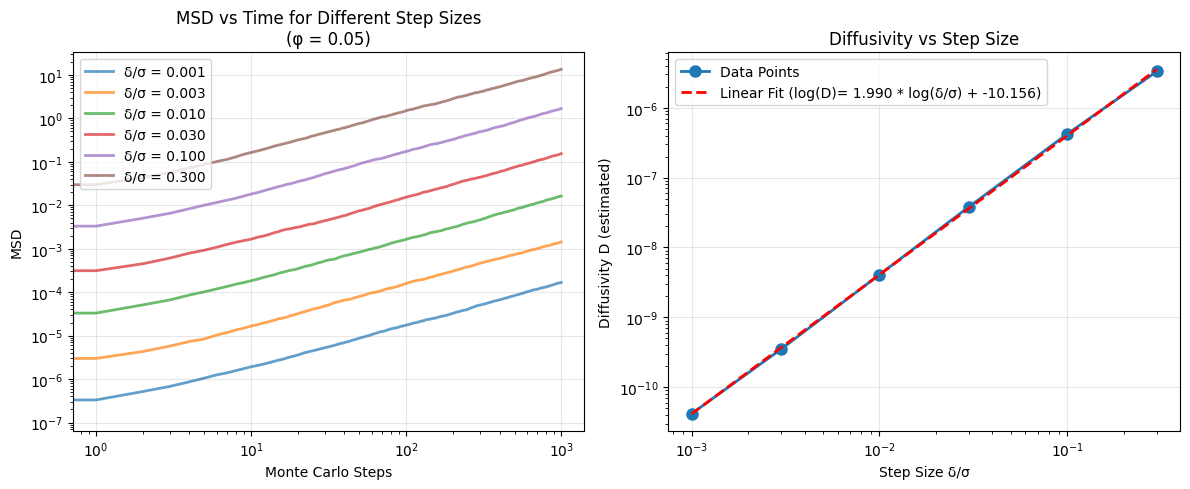

In [5]:
# Part 1
print("=== PART 1 ===")
pos_0 = initialize_positions_fast(N, L, sigma)
print(f"System: N={N}, φ={phi}, L={L:.2f}, σ={sigma}")

# Pre-compile
_ = min_image_distance_vectorized(pos_0[0:1], pos_0[1:2], L)
_ = check_overlap_vectorized(pos_0, 0, pos_0[0], sigma, L)
_ = MSD_vectorized(pos_0, pos_0, L)

print("Running Monte Carlo simulations...")
msd_vs_time, final_positions = run_simulation_parallel(delta_values, pos_0, L, sigma, MC_steps)

# Plot Part 1 results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
time_steps = np.arange(MC_steps)
for i, delta in enumerate(delta_values):
    plt.loglog(time_steps, msd_vs_time[i], 
               label=f'δ/σ = {delta_ratios[i]:.3f}', alpha=0.7, linewidth=2)
plt.xlabel('Monte Carlo Steps')
plt.ylabel('MSD')
plt.title('MSD vs Time for Different Step Sizes\n(φ = 0.05)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
diffusivities = []
for i in range(len(delta_values)): #Obtain D from linear fit
    coeffs = np.polyfit(time_steps, msd_vs_time[i], 1)
    D_est = coeffs[0] / (4 * MC_steps)
    diffusivities.append(D_est)


plt.plot(delta_ratios, diffusivities, 'o-', linewidth=2, markersize=8, label='Data Points')
#Plot linear fit line in log-log scale
fit_coeffs = np.polyfit(np.log(delta_ratios), np.log(diffusivities), 1)
fit_line = np.polyval(fit_coeffs, np.log(delta_ratios))
plt.plot(delta_ratios, np.exp(fit_line), 'r--', linewidth=2, label='Linear Fit (log(D)= {:.3f} * log(δ/σ) + {:.3f})'.format(fit_coeffs[0], fit_coeffs[1]))
plt.xlabel('Step Size δ/σ')
plt.ylabel('Diffusivity D (estimated)')
plt.title('Diffusivity vs Step Size')
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.show()



# Part 2


=== PART 2 ===


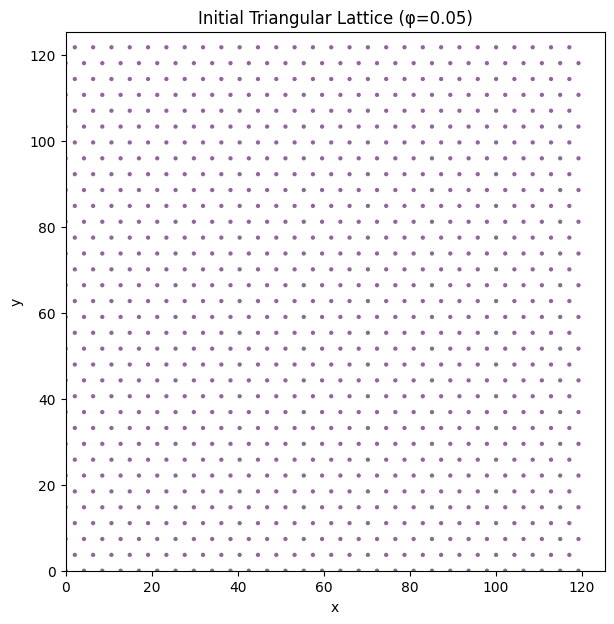

  Delta = 0.001σ
  Delta = 0.003σ
  Delta = 0.003σ
  Delta = 0.010σ
  Delta = 0.010σ
  Delta = 0.030σ
  Delta = 0.030σ
  Delta = 0.100σ
  Delta = 0.100σ
  Delta = 0.300σ
  Delta = 0.300σ


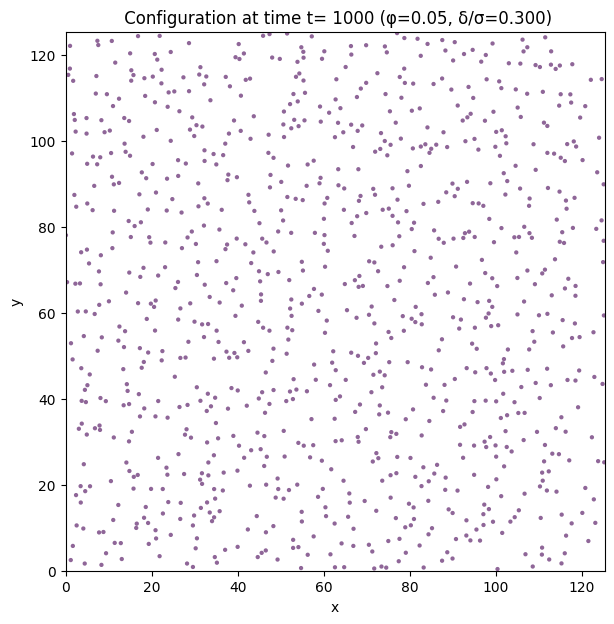

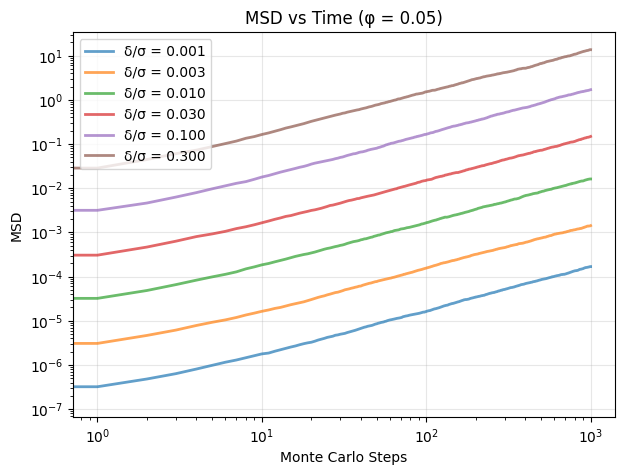

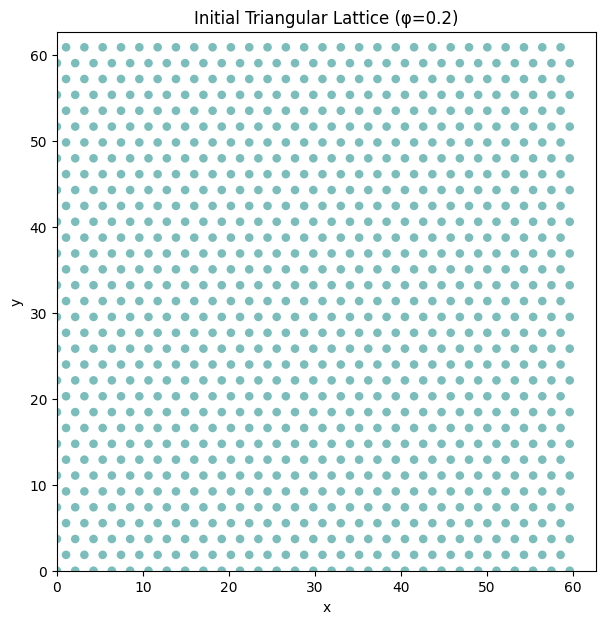

  Delta = 0.001σ
  Delta = 0.003σ
  Delta = 0.003σ
  Delta = 0.010σ
  Delta = 0.010σ
  Delta = 0.030σ
  Delta = 0.030σ
  Delta = 0.100σ
  Delta = 0.100σ
  Delta = 0.300σ
  Delta = 0.300σ


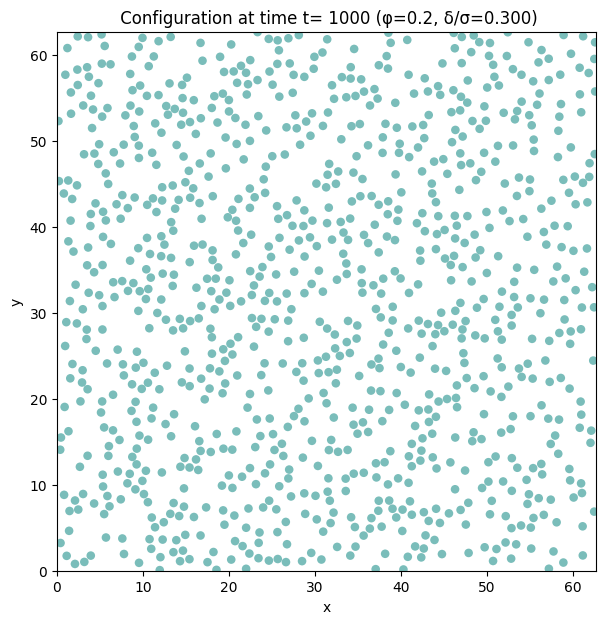

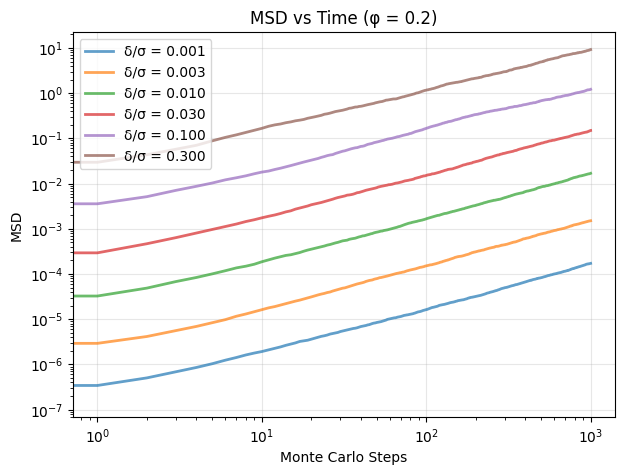

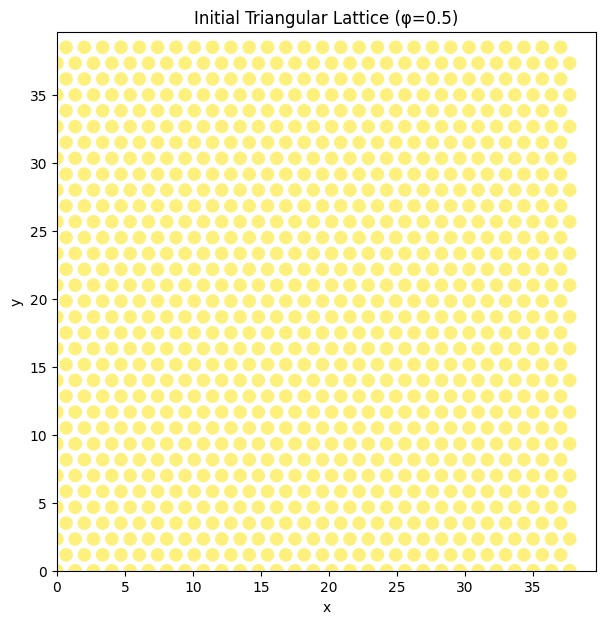

  Delta = 0.001σ
  Delta = 0.003σ
  Delta = 0.003σ
  Delta = 0.010σ
  Delta = 0.010σ
  Delta = 0.030σ
  Delta = 0.030σ
  Delta = 0.100σ
  Delta = 0.100σ
  Delta = 0.300σ
  Delta = 0.300σ


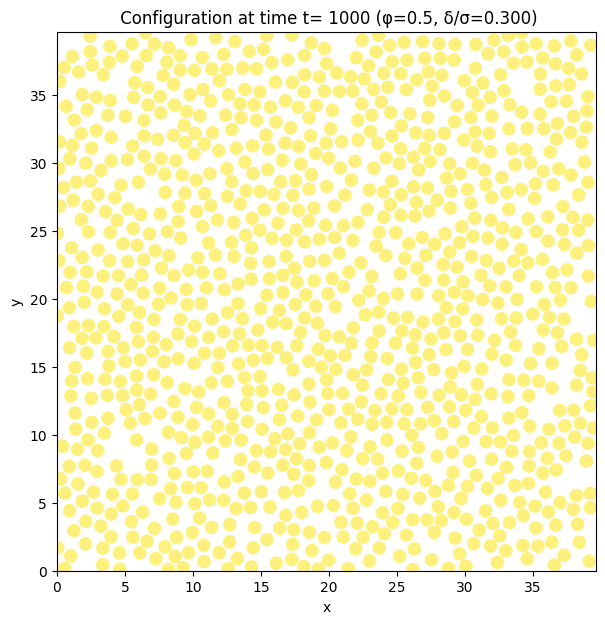

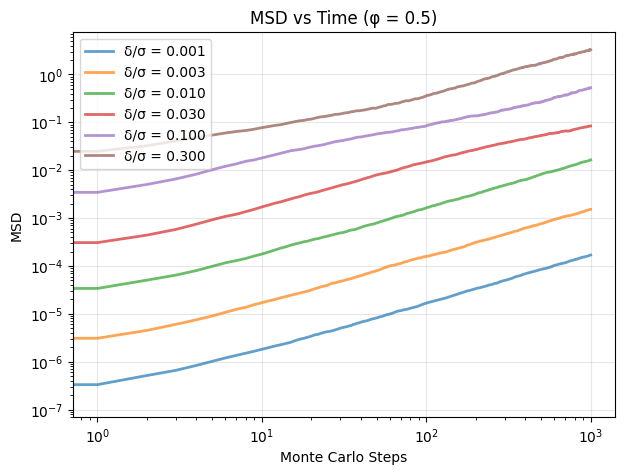

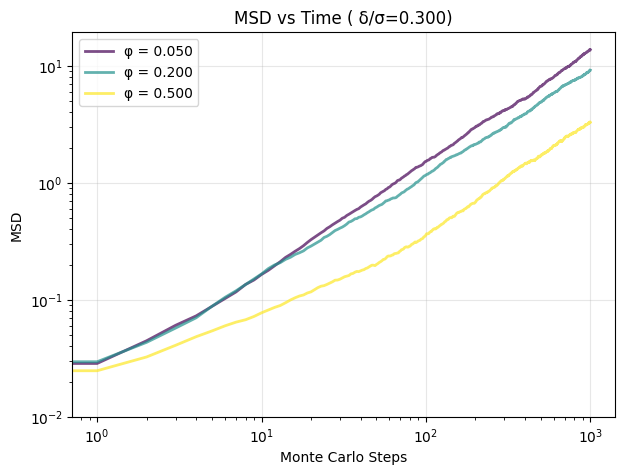

In [15]:
# Part 2
print("\n=== PART 2 ===")
phi_vals = [0.05, 0.2, 0.5]
# Create a color map for the different phi values
colors = plt.cm.viridis(np.linspace(0, 1, len(phi_vals)))
# MSD for each phi for largest delta
MSD_values = []
for idx, phi in enumerate(phi_vals):

    L = np.sqrt(N * np.pi * sigma**2 / (4 * phi))
    
    # Use triangular lattice function
    pos_0 = triangular_lattice(N, L, phi, sigma)
    
    # Plot initial configuration (disks with diameter = sigma)
    plt.figure(figsize=(7, 7))
    ax = plt.gca()
    plot_disks(ax, pos_0, sigma, facecolor=colors[idx], alpha=0.6)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Initial Triangular Lattice (φ={phi})')
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    plt.show()
    
    # Run simulation
    msd_vs_time, final_positions = run_simulation_parallel(delta_values, pos_0, L, sigma, MC_steps)
    
    # Plot last delta value's final configuration (disks with diameter = sigma)
    plt.figure(figsize=(7, 7))
    last_positions = final_positions[-1]  # Only the last delta value
    ax = plt.gca()
    plot_disks(ax, last_positions, sigma, facecolor=colors[idx], alpha=0.6)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f' Configuration at time t= {MC_steps} (φ={phi}, δ/σ={delta_ratios[-1]:.3f})')
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    plt.show()
    
    # Plot MSD vs time
    plt.figure(figsize=(7, 5))
    time_steps = np.arange(MC_steps)
    for i, delta in enumerate(delta_values):
        plt.loglog(time_steps, msd_vs_time[i], 
                   label=f'δ/σ = {delta_ratios[i]:.3f}', alpha=0.7, linewidth=2)
    plt.xlabel('Monte Carlo Steps')
    plt.ylabel('MSD')
    plt.title(f'MSD vs Time (φ = {phi})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    # Store MSD for largest delta
    MSD_values.append(msd_vs_time[-1])  # Last delta value

# Plot MSD for each phi
plt.figure(figsize=(7, 5))
time_steps = np.arange(MC_steps)
for i, phi in enumerate(phi_vals):
    plt.loglog(time_steps, MSD_values[i], label=f'φ = {phi:.3f}', alpha=0.7, linewidth=2, color =colors[i])
plt.xlabel('Monte Carlo Steps')
plt.ylabel('MSD')
plt.title(f'MSD vs Time ( δ/σ={delta_ratios[-1]:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

  Delta = 0.300σ


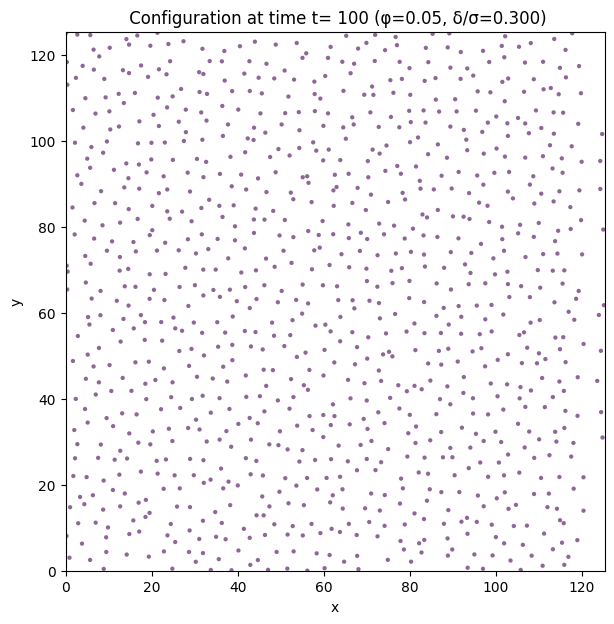

  Delta = 0.300σ


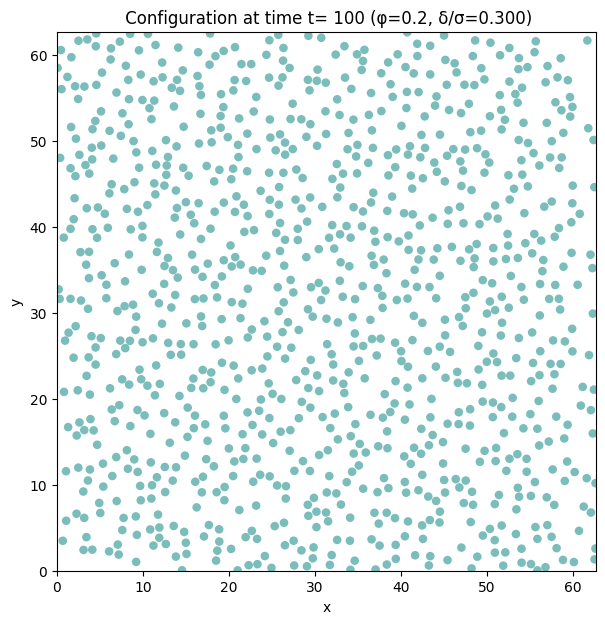

  Delta = 0.300σ


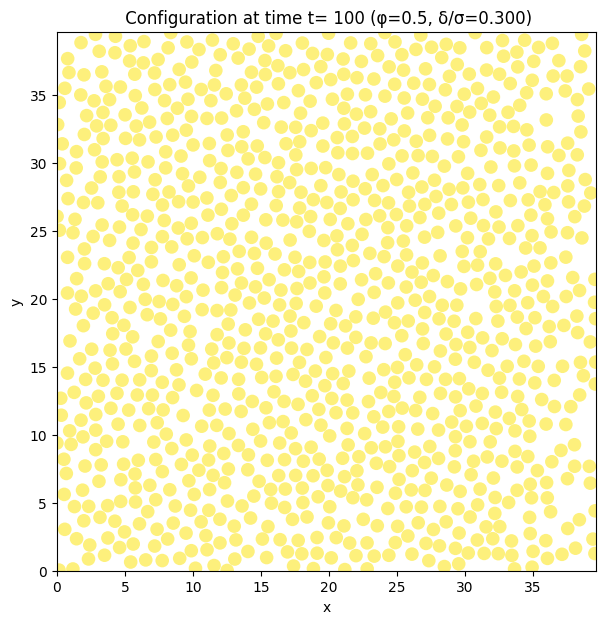

In [10]:
phi_vals = [0.05, 0.2, 0.5]
MC_steps = 100

# Create a color map for the different phi values
colors = plt.cm.viridis(np.linspace(0, 1, len(phi_vals)))
for idx, phi in enumerate(phi_vals):
    L = np.sqrt(N * np.pi * sigma**2 / (4 * phi))
    
    # Use CORRECTED triangular lattice function
    pos_0 = triangular_lattice(N, L, phi, sigma)
    
    
    
    # Run simulation
    msd_vs_time, final_positions = run_simulation_parallel(delta_values, pos_0, L, sigma, MC_steps)
    
    # Plot last delta value's final configuration (disks with diameter = sigma)
    plt.figure(figsize=(7, 7))
    last_positions = final_positions[-1]  # Only the last delta value
    ax = plt.gca()
    plot_disks(ax, last_positions, sigma, facecolor=colors[idx], alpha=0.6)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f' Configuration at time t= {MC_steps} (φ={phi}, δ/σ={delta_ratios[-1]:.3f})')
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    plt.show()
    
    

## Exercise 3


=== PART 3 ===
System: N=1000, φ=0.05, L=125.33, σ=1.0
Running Monte Carlo simulations...
  Delta = 0.001σ
  Delta = 0.003σ
  Delta = 0.010σ
  Delta = 0.030σ
  Delta = 0.100σ
  Delta = 0.300σ


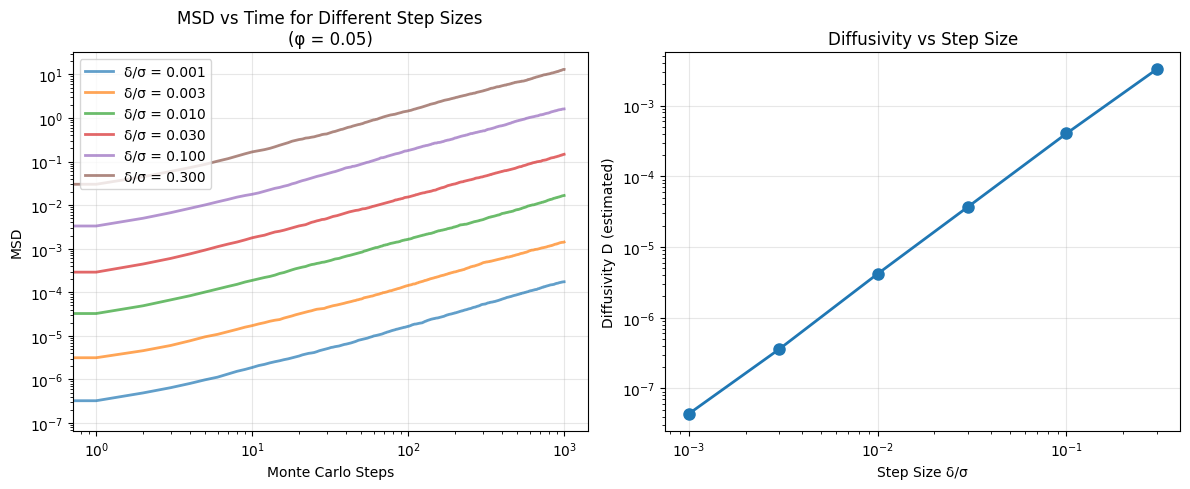

In [ ]:
# Part 3
print("\n=== PART 3 ===")
# Trying closed box boundary conditions
# Same parameters as Part 1 
pos_0 = initialize_positions_fast(N, L, sigma)
print(f"System: N={N}, φ={phi}, L={L:.2f}, σ={sigma}")

# Pre-compile
_ = min_image_distance_vectorized(pos_0[0:1], pos_0[1:2], L)
_ = check_overlap_vectorized(pos_0, 0, pos_0[0], sigma, L)
_ = MSD_vectorized(pos_0, pos_0, L)

print("Running Monte Carlo simulations...")
msd_vs_time, final_positions = run_simulation_parallel_closed_box(delta_values, pos_0, L, sigma, MC_steps)

# Plot final positions for largest delta
plt.figure(figsize=(7, 7))
last_positions = final_positions[-1]  # Only the last delta value
ax = plt.gca()
plot_disks(ax, last_positions, sigma, facecolor='C0', alpha=0.6)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Final Configuration at t={MC_steps} (Closed Box, δ/σ={delta_ratios[-1]:.3f})')
ax.set_xlim(0, L)
ax.set_ylim(0, L)
plt.show()


## Exercise 4


=== PART 4 ===
System: N=1000, φ=0.05, Lx=50.00, Ly=500.00, σ=1.0
Running Monte Carlo simulations...
  Delta = 0.001σ
  Delta = 0.003σ
  Delta = 0.010σ
  Delta = 0.030σ
  Delta = 0.100σ
  Delta = 0.300σ


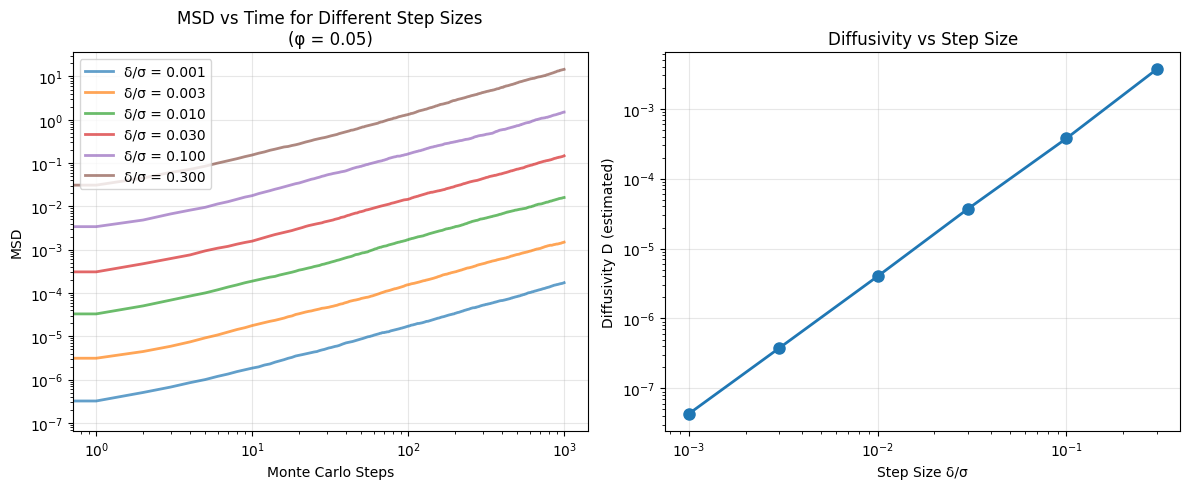

In [ ]:
# Part 4
print("\n=== PART 4 ===")
# Trying gravity in closed box boundary conditions
# Same parameters as Part 1 
pos_0 = initialize_positions_fast_rectangle(N, Lx, Ly, sigma)
print(f"System: N={N}, φ={phi}, Lx={Lx:.2f}, Ly={Ly:.2f}, σ={sigma}")

# Pre-compile
_ = min_image_distance_vectorized(pos_0[0:1], pos_0[1:2], Lx)
_ = check_overlap_vectorized(pos_0, 0, pos_0[0], sigma, Lx)
_ = MSD_vectorized(pos_0, pos_0, L)
# Choose a gravity value for pre-compilation
g_compile = G[2]  # e.g., g = 0.1
_ = metropolis_step_with_gravity(pos_0, delta_values[0], Lx, Ly, sigma, g_compile, m, kT)
print("Running Monte Carlo simulations...")
msd_vs_time, final_positions = run_simulation_parallel_gravity(delta_values, pos_0, Lx, Ly, sigma, MC_steps,g_compile, m, kT)

# Plot final positions for largest delta
plt.figure(figsize=(7, 7))
last_positions = final_positions[-1]  # Only the last delta value
ax = plt.gca()      
plot_disks(ax, last_positions, sigma, facecolor='C0', alpha=0.6)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Final Configuration at t={MC_steps} (Gravity g={g_compile}, δ/σ={delta_ratios[-1]:.3f})')
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
plt.show()  

## Exercise 5


=== PART 5 ===
System: N=1000, φ=0.05, Lx=15.00, Ly=150.00, σ=1.0

Running simulation for g=0
  Delta = 0.300σ


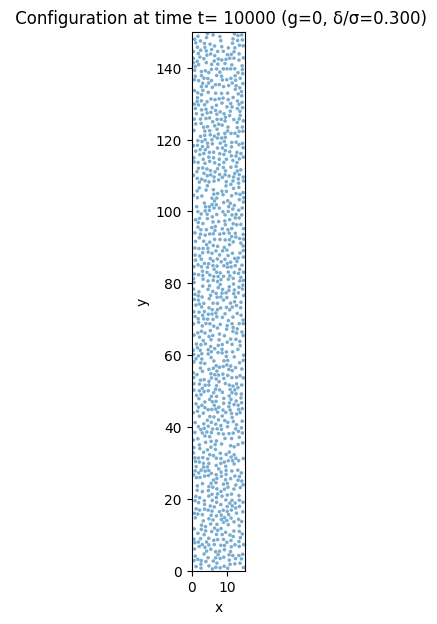


Running simulation for g=0.01
  Delta = 0.300σ


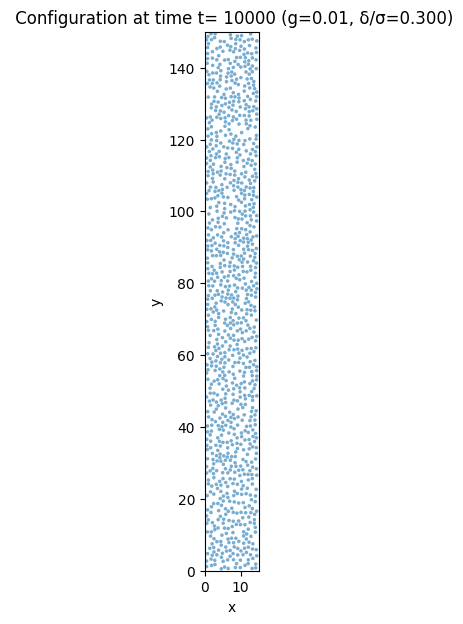


Running simulation for g=0.1
  Delta = 0.300σ


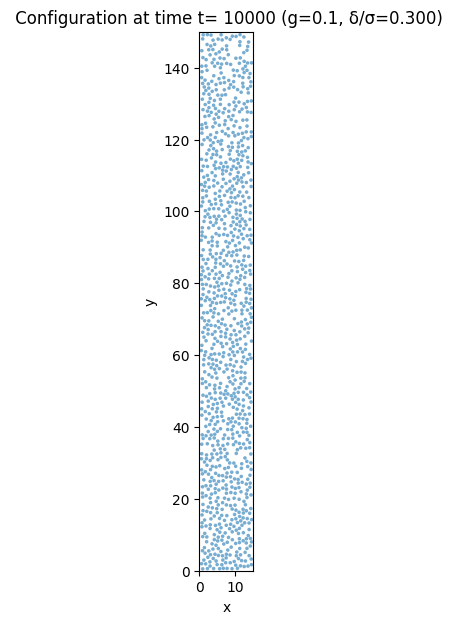


Running simulation for g=1
  Delta = 0.300σ


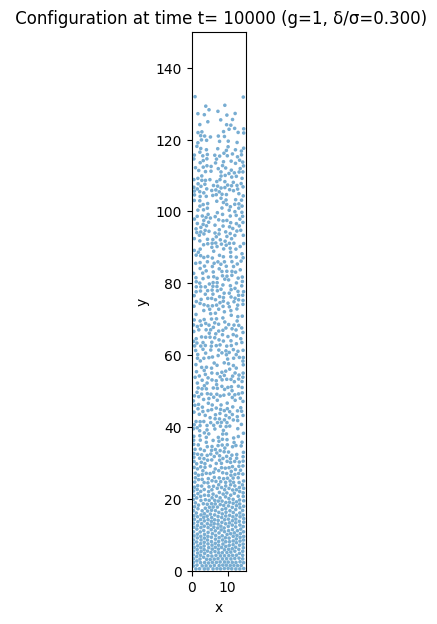


Running simulation for g=10
  Delta = 0.300σ


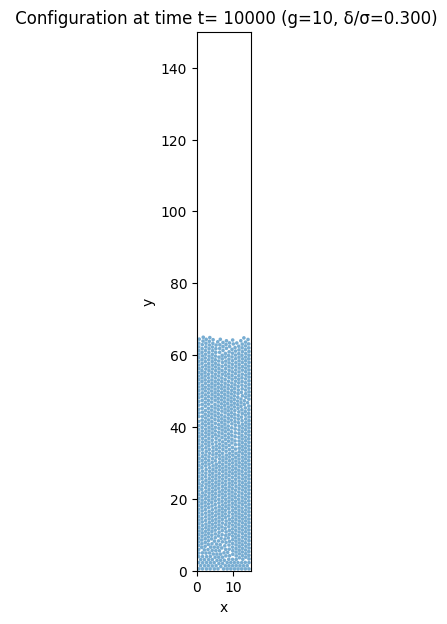

In [27]:
# Part 5
print("\n=== PART 5 ===")
# Plot equilibrium configurations for different gravity values
# Same parameters as Part 1 
Lx=15
Ly=10 * Lx
delta_ratios = np.array([0.3]) #Only the largest delta ratio
delta_values = delta_ratios * sigma
MC_steps = 10000

pos_0 = initialize_positions_fast_rectangle(N, Lx, Ly, sigma)
print(f"System: N={N}, φ={phi}, Lx={Lx:.2f}, Ly={Ly:.2f}, σ={sigma}")
for g in G:
    print(f"\nRunning simulation for g={g}")
    # Pre-compile
    _ = min_image_distance_vectorized(pos_0[0:1], pos_0[1:2], Lx)
    _ = check_overlap_vectorized(pos_0, 0, pos_0[0], sigma, Lx)
    _ = MSD_vectorized(pos_0, pos_0, L)
    _ = metropolis_step_with_gravity(pos_0, delta_values[0], Lx, Ly, sigma, g, m, kT)
    
    msd_vs_time, final_positions = run_simulation_parallel_gravity(delta_values, pos_0, Lx, Ly, sigma, MC_steps,g, m, kT)
    
    # Plot last delta value's final configuration (disks with diameter = sigma)
    plt.figure(figsize=(7, 7))
    last_positions = final_positions[-1]  # Only the last delta value
    ax = plt.gca()
    plot_disks(ax, last_positions, sigma, facecolor='C0', alpha=0.6)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f' Configuration at time t= {MC_steps} (g={g}, δ/σ={delta_ratios[-1]:.3f})')
    ax.set_xlim(0, Lx)
    ax.set_ylim(0, Ly)
    plt.show()


=== PART 5 ===
System: N=1000, φ=0.05, Lx=15.00, Ly=150.00, σ=1.0

Running simulation for g=0
  Delta = 0.300σ


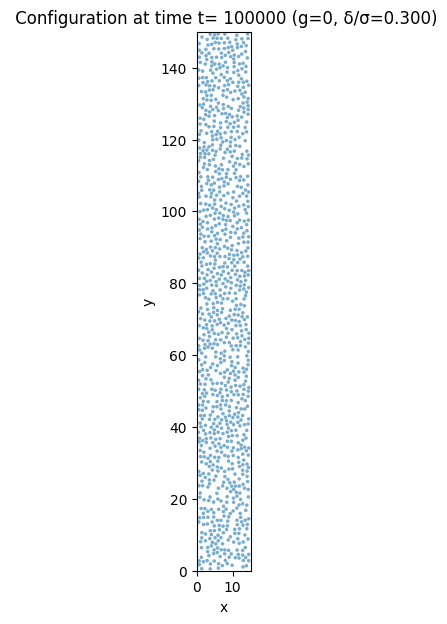


Running simulation for g=0.01
  Delta = 0.300σ


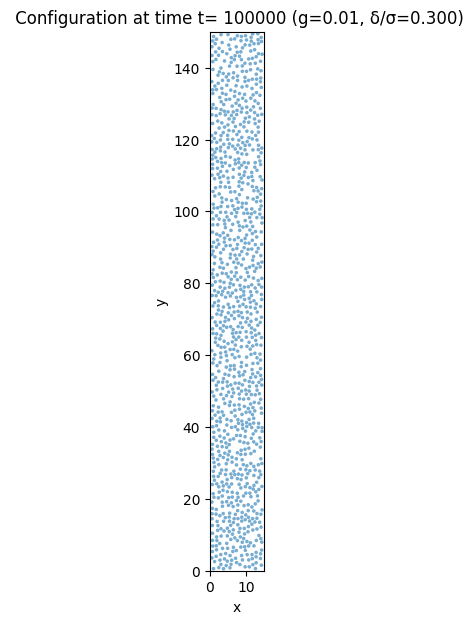


Running simulation for g=0.1
  Delta = 0.300σ


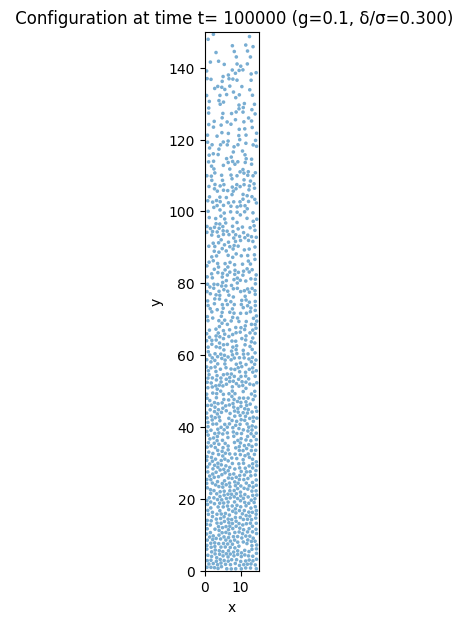


Running simulation for g=1
  Delta = 0.300σ


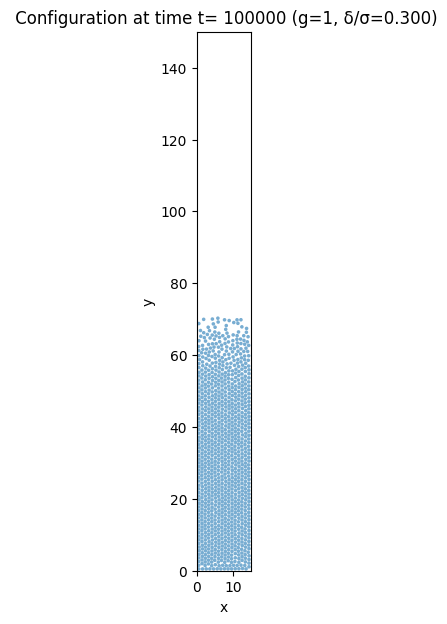


Running simulation for g=10
  Delta = 0.300σ


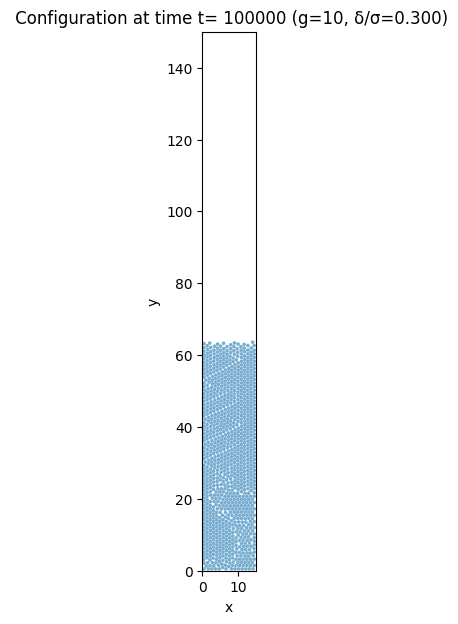

In [6]:
# Part 5
print("\n=== PART 5 ===")
# Plot equilibrium configurations for different gravity values
# Same parameters as Part 1 
Lx=15
Ly=10 * Lx
MC_steps = 100000
delta_ratios = np.array([0.3]) #Only the largest delta ratio
delta_values = delta_ratios * sigma

pos_0 = initialize_positions_fast_rectangle(N, Lx, Ly, sigma)
print(f"System: N={N}, φ={phi}, Lx={Lx:.2f}, Ly={Ly:.2f}, σ={sigma}")
for g in G:
    print(f"\nRunning simulation for g={g}")
    # Pre-compile
    _ = min_image_distance_vectorized(pos_0[0:1], pos_0[1:2], Lx)
    _ = check_overlap_vectorized(pos_0, 0, pos_0[0], sigma, Lx)
    _ = MSD_vectorized(pos_0, pos_0, L)
    _ = metropolis_step_with_gravity(pos_0, delta_values[0], Lx, Ly, sigma, g, m, kT)
    
    msd_vs_time, final_positions = run_simulation_parallel_gravity(delta_values, pos_0, Lx, Ly, sigma, MC_steps,g, m, kT)
    
    # Plot last delta value's final configuration (disks with diameter = sigma)
    plt.figure(figsize=(7, 7))
    last_positions = final_positions[-1]  # Only the last delta value
    ax = plt.gca()
    plot_disks(ax, last_positions, sigma, facecolor='C0', alpha=0.6)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f' Configuration at time t= {MC_steps} (g={g}, δ/σ={delta_ratios[-1]:.3f})')
    ax.set_xlim(0, Lx)
    ax.set_ylim(0, Ly)
    plt.show()